In [1]:
import sys
sys.path.append("./utls")
sys.path.append("./preprocessing")
from preprocessing import *
import os
import string
import subprocess
from natsort import natsorted
from InterfaceDeclaration import LPBFData
from utls.preprocessing import MaPS_LPBF_Construction
from utls.preprocessing import fill_nan
from construct_roi_adjacent_labels import fourier_transform1d_interp
import pickle
import pandas as pd

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
with open(os.path.join(os.path.dirname(daq_dir),'intermediate',f"lpbf_line_wise_data.pkl"), "rb") as fp:   
    lpbf_data = pickle.load(fp)

In [2]:
target_freq = 600000
target_length = 6000
common_freqs = np.linspace(0, target_freq, target_length)
scanning_vector = np.asarray(np.round(lpbf_data.print_vector[1]),dtype=int)
lpbf_data.print_vector = scanning_vector
uni_direction = list(np.unique(scanning_vector))
uni_direction.pop(2)
uni_position = range(5)
uni_direction

[-150, -60, 30, 120]

## Population diff

In [3]:
populations = []
for _c,_u in enumerate([-150,30,-60,120]):
    _AE_i = (np.where(scanning_vector==_u)[0])
    _AE = [lpbf_data.AE[i] for i in _AE_i]
    populations.append(len(_AE))

In [4]:
populations, np.sum(populations)

([27830, 27811, 34194, 34284], 124119)

In [5]:
df_context = pd.DataFrame({
    "Direction":lpbf_data.print_vector, 
    "Position":lpbf_data.cube_position}
    )
df_context

,Direction,Position
0,30,0
1,-150,0
2,30,0
3,-150,0
4,30,0
...,...,...
124338,30,4
124339,-150,4
124340,30,4
124341,-150,4


In [6]:
_index = np.asarray(df_context[(df_context['Direction']==30) & (df_context['Position']==4)].index,dtype=int)
_index

array([   394,    396,    398, ..., 124338, 124340, 124342])

In [7]:
_AE = [lpbf_data.AE[i] for i in _index]
_ft = fourier_transform1d_interp(_AE,sampling_rate_daq,target_freq=target_freq,target_length=target_length, verbose=False)

In [8]:
def getFT(i_r, i_c):
    _index = np.asarray(df_context[(df_context['Direction']==uni_direction[i_r]) & (df_context['Position']==uni_position[i_c])].index,dtype=int)
    _AE = [lpbf_data.AE[i] for i in _index]
    _ft = fourier_transform1d_interp(_AE,sampling_rate_daq,target_freq=target_freq,target_length=target_length, verbose=False)
    return _ft[0]

In [9]:
i_r = 0
i_c = 4
_ft = getFT(i_r,i_c)

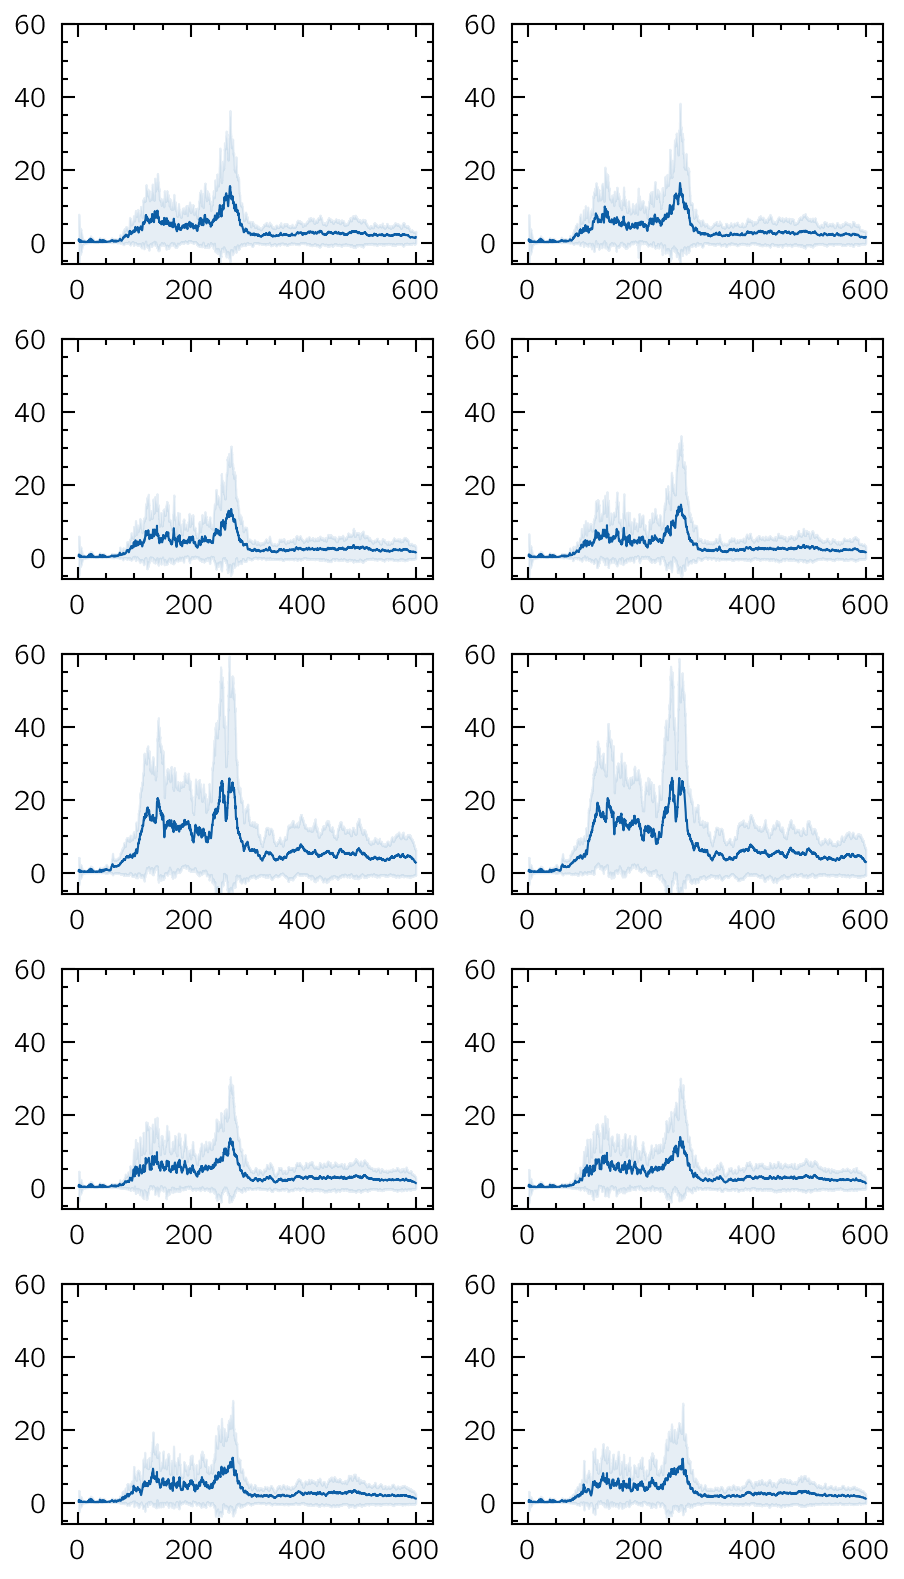

In [27]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use']=True
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(3.0,2.625*2))
for i_c in range(5):
    for i_x,i_r in enumerate(([0,1],[2,3])):
        ft0 = []
        for _i_r in i_r:
            _ft = getFT(_i_r,i_c)
            _ft = np.where(np.isnan(_ft), 0, _ft)
            ft0.append(_ft)
        _ft = np.concatenate(ft0,axis=0)
        mean_values = np.mean(np.abs(_ft), axis=0)
        std_values = np.std(np.abs(_ft), axis=0)
        ax[i_c,i_x].plot(common_freqs[10:]/1e3, mean_values[10:],lw=0.5)
        ax[i_c,i_x].fill_between(common_freqs[10:]/1e3, (mean_values - std_values)[10:], (mean_values + std_values)[10:], color=cm_std[0], alpha=0.1, label="±1 STD",lw=0.5)
        ax[i_c,i_x].set_ylim(-6,60)
plt.savefig(f"./outputs/raw_statistical_diff.png",dpi=600)
plt.show()

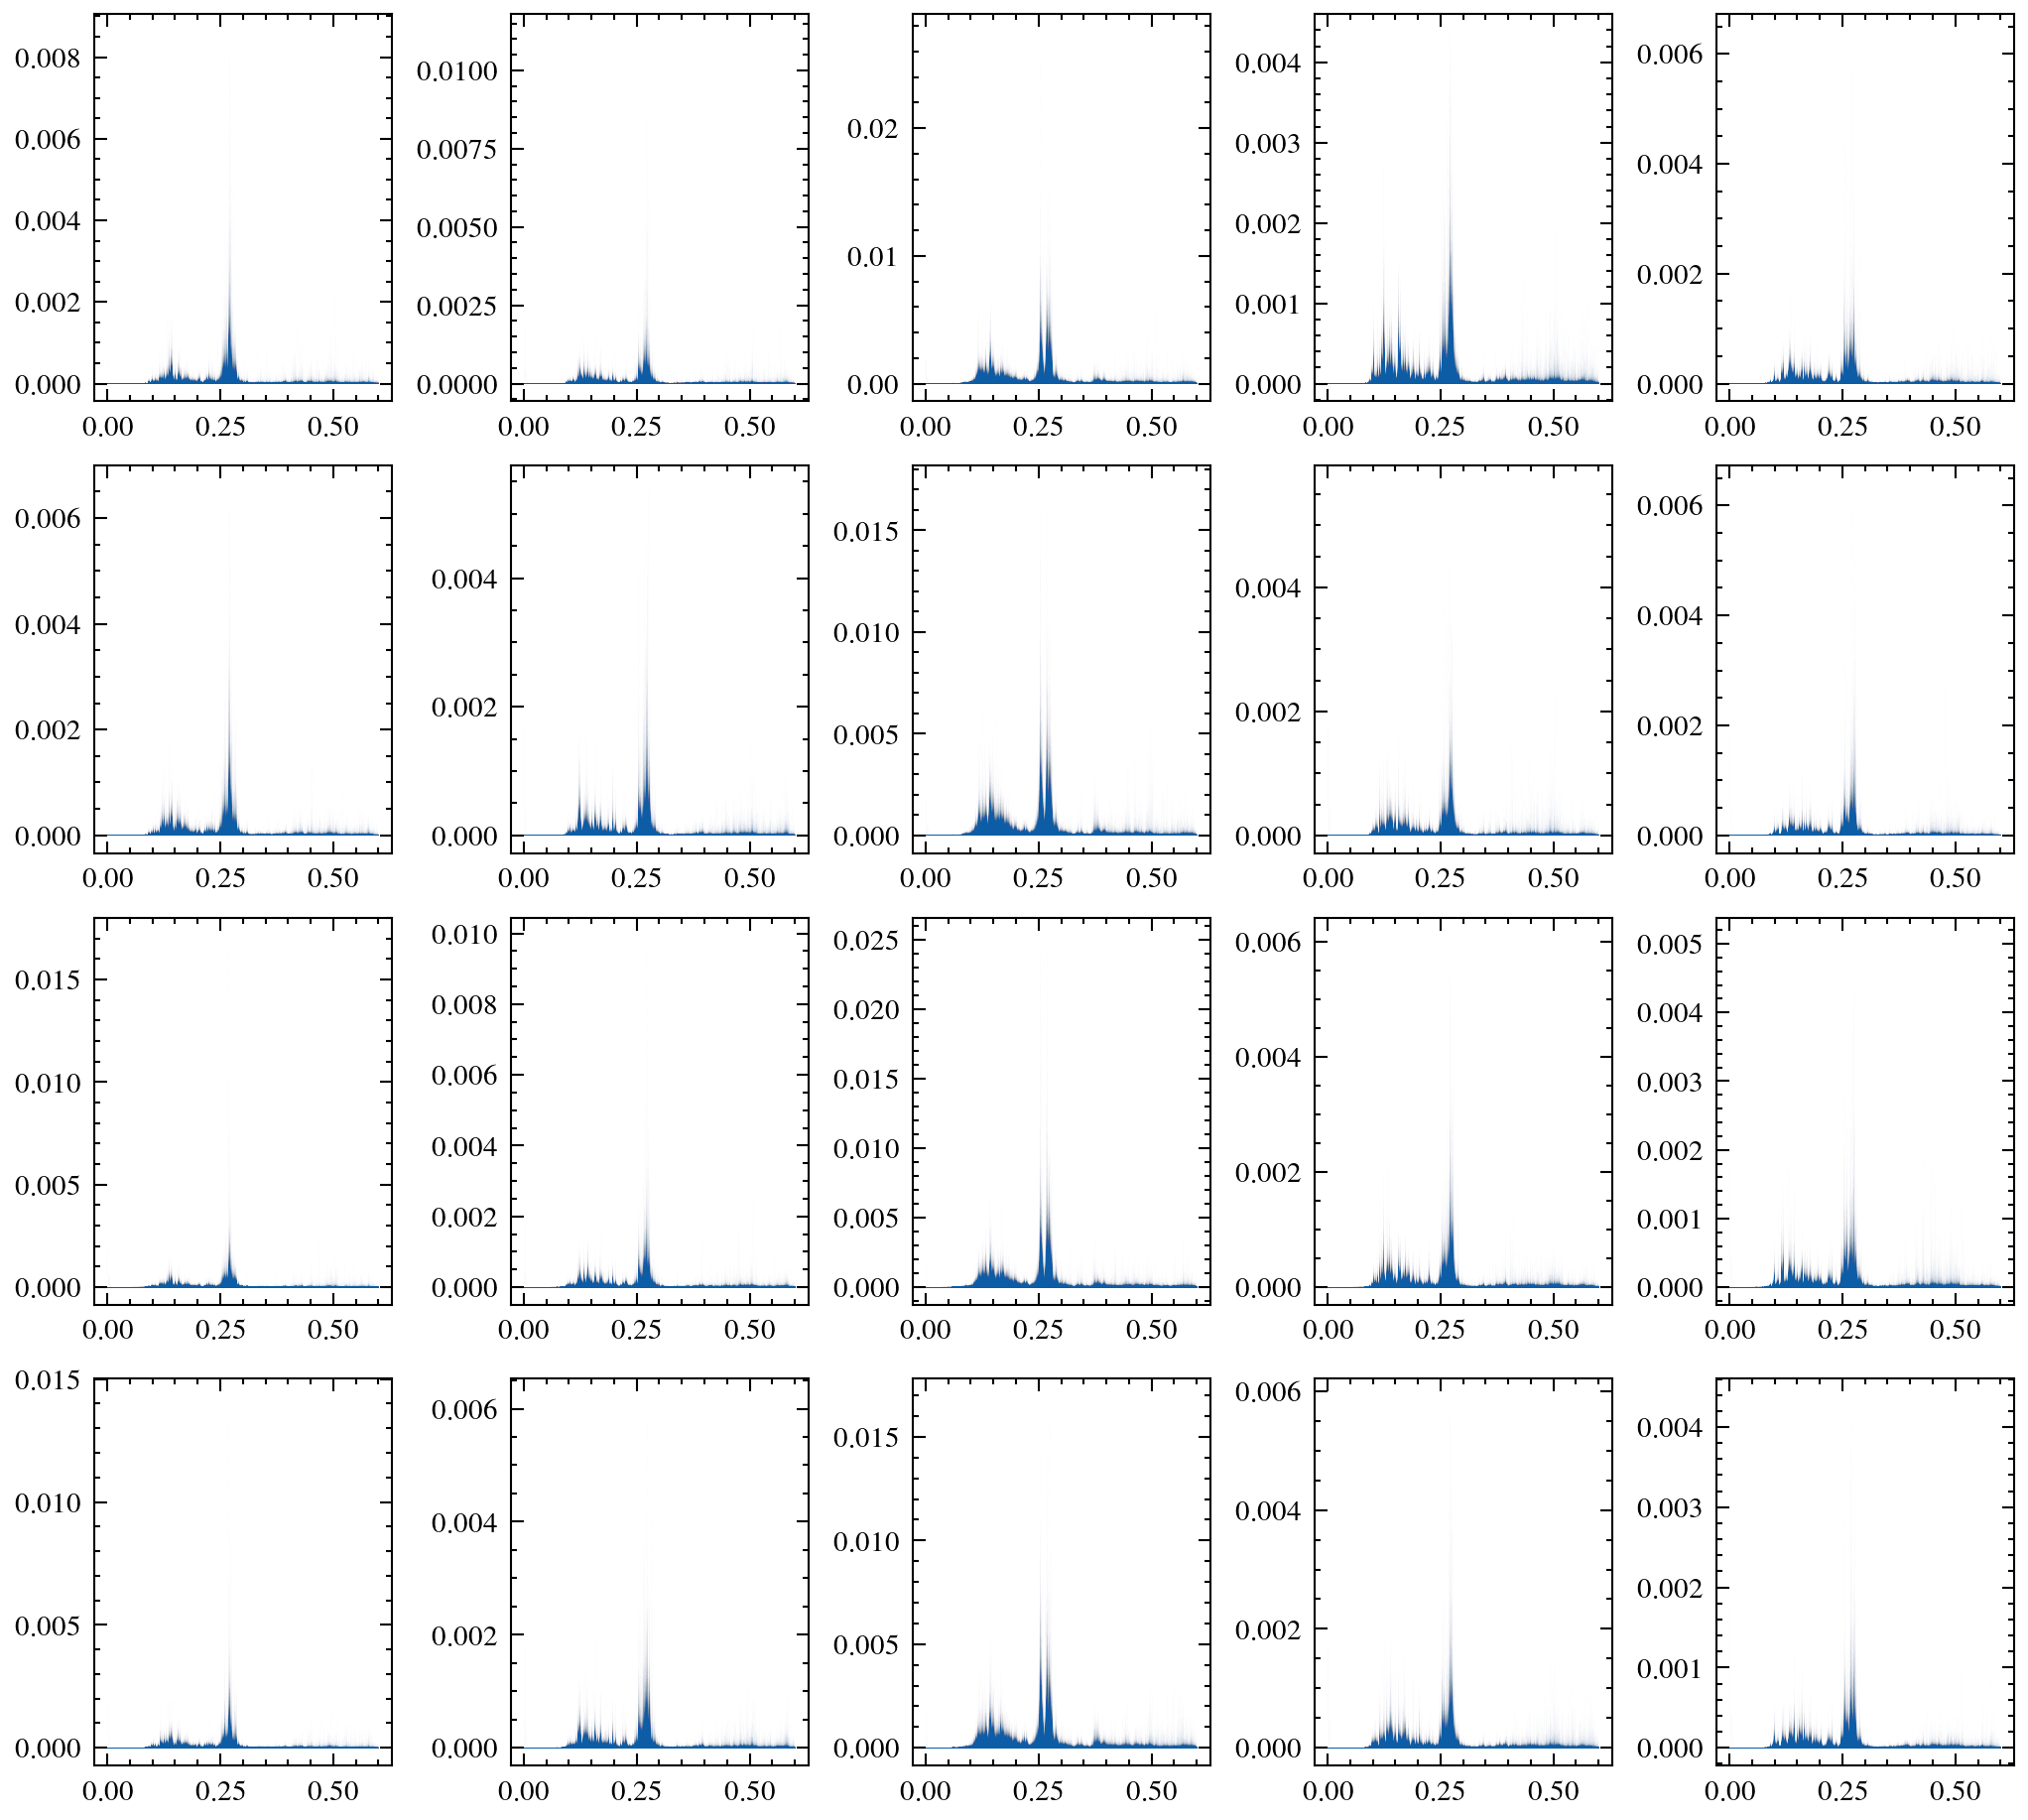

In [ ]:
# plt.rcParams.update(two_column)
# plt.rcParams['figure.constrained_layout.use']=True
# fig,ax = plt.subplots(nrows=4,ncols=5)
# for i_r in range(4):
#     for i_c in range(5):
#         _ft = getFT(i_r,i_c)
#         for i in (_ft[0][:1000]):
#             ax[i_r,i_c].plot(common_freqs[10:]/1e3,(i[10:]**2)/1e7,lw=0.001,alpha=0.5, c=cm_std[0])
#             ax[i_r,i_c].set_ylim(0,8)
# plt.savefig(f"./outputs/raw_statistical_diff.png",dpi=600)
# plt.show()

## FT diff

In [ ]:
for _c,_u in enumerate(uni[:1]):
    _AE_i = (np.where(scanning_vector==_u)[0])
    _AE = [lpbf_data.AE[i] for i in _AE_i]
    _ft = fourier_transform1d_interp(_AE,sampling_rate_daq,target_freq=target_freq,target_length=target_length, verbose=False)
    # fig,ax = plt.subplots()
    # for i in (_ft[0]):
    #     ax.plot(common_freqs[10:]/1e6,(i[10:]**2)/1e5,lw=0.01,alpha=0.2, c=cm_std[0])
    # ax.set_ylabel(f"Amplitude")
    # ax.set_xlabel(f"Frequency (MHz)")
    # # ax.set_ylim(-0.1,2.3)
    # ax.set_ylim(1e-13,np.log(2.3))
    # ax.set_yscale('log')
    # plt.savefig(f"./outputs/raw_PSD_DirectionDiff_with_{_u}")
    # plt.show()

In [11]:
_f_mean = fill_nan(_ft[0])
_f_mean = np.mean(_f_mean,axis=0)

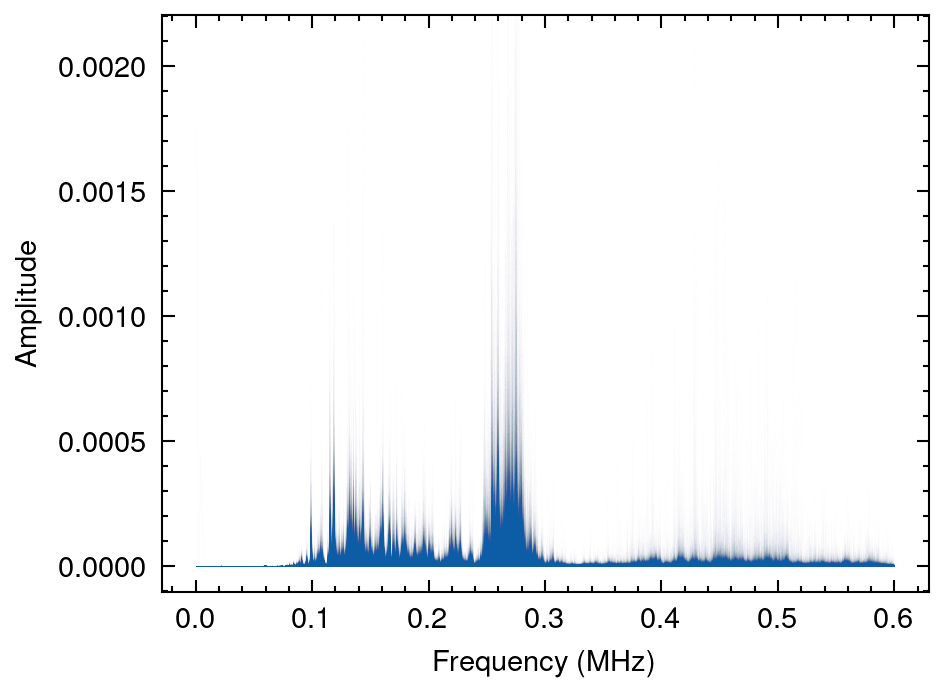

In [13]:
fig,ax = plt.subplots()
for i in (_ft[0][:1000]):
    ax.plot(common_freqs[10:]/1e6,(i[10:]**2)/1e7,lw=0.001,alpha=0.5, c=cm_std[0])
# ax.plot(common_freqs[10:]/1e6,_f_mean[10:]**2/1e2,lw=0.1,alpha=1, c=cm_std[2])
ax.set_ylabel(f"Amplitude")
ax.set_xlabel(f"Frequency (MHz)")
ax.set_ylim(-0.00010504062833773374, 0.002205853198507621)
# ax.set_ylim(0.9e-13,np.log(2.5))
# ax.set_yscale('log')
# plt.savefig(f"./outputs/raw_PSD_DirectionDiff_with_{_u}")
plt.show()

In [ ]:
fig,ax = plt.subplots()
for i in (_ft[0][:10]):
    ax.plot(common_freqs[10:]/1e6,(i[10:]**2)/1e6,lw=0.005,alpha=0.5, c=cm_std[0])
ax.scatter(common_freqs[10:]/1e6,np.mean(_f,axis=0)[10:],s=0.01,alpha=1, c=cm_std[1])
ax.set_ylabel(f"Amplitude")
ax.set_xlabel(f"Frequency (MHz)")
# ax.set_ylim(-0.1,2.3)
ax.set_ylim(0.9e-13,np.log(2.5))
ax.set_yscale('log')
# plt.savefig(f"./outputs/raw_PSD_DirectionDiff_with_{_u}")
plt.show()